In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import random
#from plot_audio import plot_specgram, plot_waveform
os.getcwd()

/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


'/Users/jansta/learn/acoustics'

In [3]:
dict_mats = np.load('/Users/jansta/learn/acoustics/dict_mats_dB.npy', allow_pickle=True).item()


In [4]:
len(dict_mats['A']['can_opening'][3])

all_labels = dict_mats['A'].keys()
print(all_labels)

dict_keys(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow', 'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter', 'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine', 'breathing', 'crying_baby', 'hand_saw', 'coughing', 'glass_breaking', 'snoring', 'toilet_flush', 'pig', 'washing_machine', 'clock_tick', 'sneezing', 'rooster', 'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'])


In [5]:
chosen_labels = ['crickets', 'can_opening', 'chirping_birds', 'dog', 'chainsaw'][:4]
encoded_labels = {'crickets': 0, 'can_opening': 1, 'chirping_birds': 2, 'dog': 3, 'chainsaw': 4}

In [6]:
chosen_labels = list(all_labels)[:20]
print(chosen_labels)
encoded_labels = {}
for i, label in enumerate(chosen_labels):
    encoded_labels[label] = i

['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm', 'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks', 'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train', 'sheep', 'water_drops', 'church_bells', 'clock_alarm', 'keyboard_typing', 'wind']


In [7]:
class AudioDataset(Dataset):
    def __init__(self, dict_mats, chosen_labels, encoded_labels, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        for key in dict_mats.keys():
            if key in chosen_labels:
                for i in range(len(dict_mats[key])):
                    self.X.append(dict_mats[key][i])
                    self.y.append(encoded_labels[key])
        
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        
        # Add a channel dimension
        sample = np.expand_dims(sample, axis=0)
        
        # Convert to tensor
        sample = torch.FloatTensor(sample)
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

In [8]:
transform = transforms.Compose(
    [transforms.Resize((64,431)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

In [9]:
# Create dataset with transform
dataset = AudioDataset(dict_mats['A'], chosen_labels, encoded_labels, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [10]:
# Test the dataloader
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print(f"Input batch size: {inputs.size()}")
    print(f"Labels: {labels}")
    print("-" * 30)
    break  # Just to test the first batch

Batch 1:
Input batch size: torch.Size([4, 1, 64, 431])
Labels: tensor([ 2,  3,  5, 10])
------------------------------


In [ ]:
n_classes = len(chosen_labels)

class AudioClassifNetCAM(nn.Module):
    def __init__(self, n_classes) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64, 256)  # Simplified linear layer
        #self.fc1 = nn.Linear(64 * 8 * 53, 512)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, self.n_classes)  # classes
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)
        # Store feature maps for CAM
        self.feature_maps = None
    
    def forward(self, x):
        x = self.conv1(x)  # out: (BS, 16, 64, 431)
        x = self.relu(x)
        x = self.pool(x)   # out: (BS, 16, 32, 215)
        x = self.conv2(x)  # out: (BS, 32, 32, 215)
        x = self.relu(x)
        x = self.pool(x)   # out: (BS, 32, 16, 107)
        x = self.conv3(x)  # out: (BS, 64, 8, 107)
        x = self.relu(x)
        x = self.pool(x)   # out: (BS, 64, 8, 53)
        # Store the feature maps after final convolution
        self.feature_maps = x.detach()
        x = self.global_avg_pool(x)
        x = self.flatten(x) # out: (4, 3328)
        x = self.fc1(x)  # out: (BS, 256)
        x = self.relu(x)
        x = self.fc2(x)  # out: (BS, 128)
        x = self.relu(x)
        x = self.fc3(x)  # out: (BS, n_classes)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

    def getCAM(self, class_idx):
        if self.feature_maps is None:
            raise ValueError("Feature maps are not set. Run a forward pass first.")
        
        if class_idx >= n_classes:
            raise ValueError(f"Class index {class_idx} is out of bounds for {n_classes} classes.")
        
        # Get the feature maps from the last convolutional layer
        feature_maps = self.feature_maps.squeeze(0)
        
        # Get the weights for the final fully connected layer
        weights = self.fc4.weight[class_idx].detach()
        #print(f"Weights shape before reshape: {weights.shape}")
        weights = weights.view(1,-1, 1, 1)
        #print(f"Weights shape after reshape: {weights.shape}")
    
        cam = torch.sum(feature_maps * weights, dim=1, keepdim=True)
        #print(f"CAM shape after computation: {cam.shape}")
        
        # Normalize the CAM
        cam = cam - cam.min()
        cam = cam / cam.max()
        
        return cam                 

    def generate_cam_visualization(self, cam, test_inp):
        """
        Generate CAM visualization for a given input
        Args:
            input_tensor (Tensor): Input audio spectrogram tensor
            class_idx (int): Index of the target class   
        Returns:
            visualization (ndarray): CAM visualization overlaid on input
        """
        #cam = self.getCAM(class_idx)

        # First squeeze to remove singleton dimensions
        cam = cam.squeeze(0)  # Remove batch dimension
        cam = cam.squeeze(0)  # Remove channel dimension

        # Now resize to match input dimensions
        # Get the height and width from input tensor
        height, width = test_inp.shape[1:]

        # Resize using both dimensions
        cam = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),  # Add back dimensions for interpolation
            size=(height, width),           # Use both dimensions
            mode='bilinear',
            align_corners=True
        )

        # Remove added dimensions and convert to numpy
        visualization = cam.squeeze().cpu().numpy()
        
        return visualization



In [12]:
def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {name}")
        return True
    return False

In [13]:
## Create an  instance of the model:
model = AudioClassifNetCAM()
#from helper_functions import capture_gradients, resize_cam_to_input


Epoch 0/600, Loss: 2.985783698129
Epoch 60/600, Loss: 0.489164638287
Epoch 120/600, Loss: 0.370885292836
Epoch 180/600, Loss: 0.000224153509
Epoch 240/600, Loss: 0.000000024428
Epoch 300/600, Loss: 0.000000000000
Epoch 360/600, Loss: 0.000000000000
Epoch 420/600, Loss: 0.000000000000
Epoch 480/600, Loss: 0.000000000000
Epoch 540/600, Loss: 0.000000000000


<Axes: >

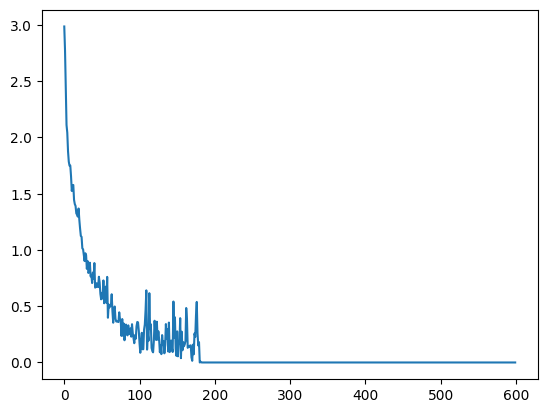

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00075)

# %% TRAINING
losses_epoch_mean = []
NUM_EPOCHS = 600
for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for i, data in enumerate(train_loader):
        inputs, labels = data
        # Check for NaN loss
        if torch.isnan(inputs).any():
            print(f"NaN input at epoch {epoch}, batch {i}")
            i_err = inputs
            break
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        losses_epoch.append(loss.item())
    
    losses_epoch_mean.append(np.mean(losses_epoch))
    if epoch % int(NUM_EPOCHS/10) == 0:
        print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {np.mean(losses_epoch):.12f}')

sns.lineplot(x=list(range(len(losses_epoch_mean))), y=losses_epoch_mean)        

In [27]:
y_val = []
y_val_hat = []
for i, data in enumerate(val_loader):
    inputs, y_val_temp = data
    with torch.no_grad():
        y_val_hat_temp = model(inputs).round()
    
    y_val.extend(y_val_temp.numpy())
    y_val_hat.extend(y_val_hat_temp.numpy())

Accuracy: 72.13 %


<Axes: >

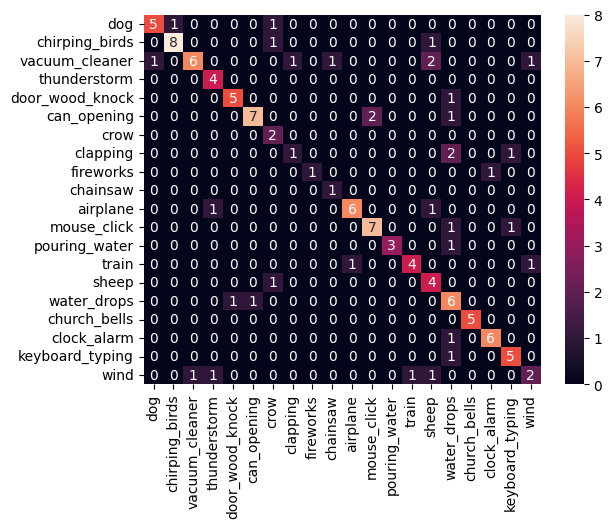

In [28]:

# Accuracy
acc = accuracy_score(y_val, np.argmax(y_val_hat, axis=1))
print(f'Accuracy: {acc*100:.2f} %')
# confusion matrix
cm = confusion_matrix(y_val, np.argmax(y_val_hat, axis=1))
sns.heatmap(cm, annot=True, xticklabels=chosen_labels, yticklabels=chosen_labels)

In [29]:
# model.feature_maps.size()

# torch.save(model.state_dict(), 'test_CAM_model.pth')

18


Text(0.5, 1.0, 'input spectrogram for -> keyboard_typing')

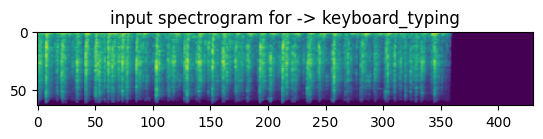

In [30]:
## get the test input and the validation class
test_inp = val_loader.dataset[0][0]

output = model(test_inp.unsqueeze(0))

pred_class = torch.argmax(output, dim=1).item()
print(pred_class)
predicted_label = list(encoded_labels.keys())[list(encoded_labels.values()).index(pred_class)]

plt.imshow(test_inp[0])
plt.title(f'input spectrogram for -> {predicted_label}')


tensor([[-9.1696e+01, -8.1221e+01, -4.6810e+01, -7.2752e+01, -1.0550e+02,
         -1.4248e+02, -6.8397e+01, -7.8592e+01, -1.0695e+02, -2.1297e+01,
         -4.4482e+00, -8.9624e+01, -1.0799e+02, -4.6373e+01, -1.3620e+01,
         -7.3510e+01, -1.1770e-02, -4.9878e+01, -6.8201e+01, -2.8860e+01]],
       grad_fn=<LogSoftmaxBackward0>)
church_bells


Text(0.5, 1.0, 'input spectrogram for -> church_bells')

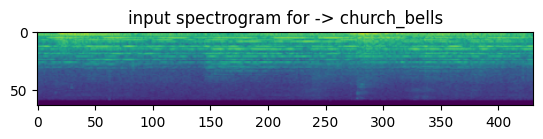

In [31]:
test_inp = val_loader.dataset[1][0]
output = model.forward(test_inp.unsqueeze(0))
print(output)
pred_class = torch.argmax(output, dim=1).item()
predicted_label = list(encoded_labels.keys())[list(encoded_labels.values()).index(pred_class)]
print(predicted_label)

plt.imshow(test_inp[0])
plt.title(f'input spectrogram for -> {predicted_label}')

In [33]:
print(c1.shape)
print(test_inp.shape)

torch.Size([1, 1, 8, 53])
torch.Size([1, 64, 431])


In [34]:
cams = {}
samples = {}
for i, data in enumerate(val_loader):
    inputs, y_val_temp = data
    #print(inputs.shape, y_val_temp.shape)
    for i in range(inputs.shape[0]):
        model.eval()
        with torch.no_grad():
            # Get the model output
            output = model(inputs[i].unsqueeze(0))
            # # Get the predicted class
            _, pred_class = torch.max(output, 1)
            predicted_label = list(encoded_labels.keys())[list(encoded_labels.values()).index(pred_class)]
            # # Generate CAM for the first input and its predicted class
            cam = model.getCAM(pred_class.item())
            cam_vis = model.generate_cam_visualization(cam, inputs[0])

            if predicted_label not in cams.keys():
                cams[predicted_label] = [cam_vis]
            else:
                cams[predicted_label].append(cam_vis)

            if predicted_label not in samples.keys():
                samples[predicted_label] = inputs[i]

            



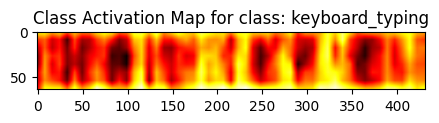

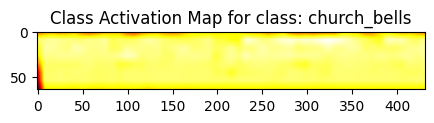

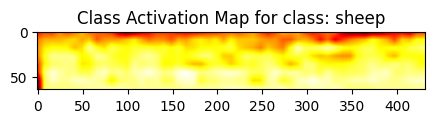

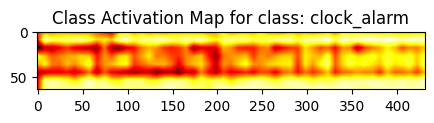

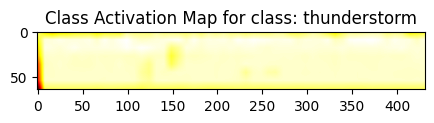

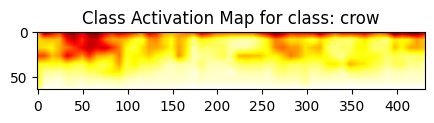

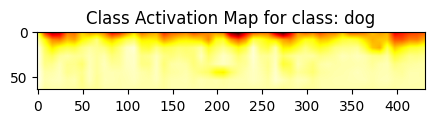

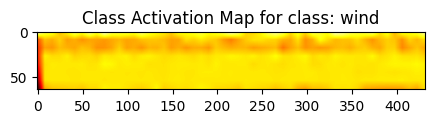

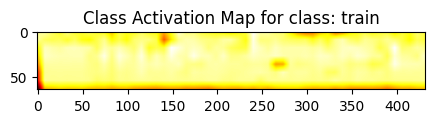

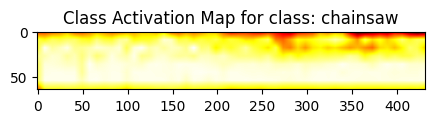

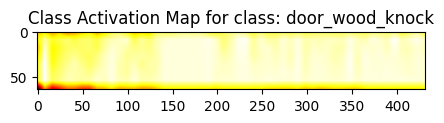

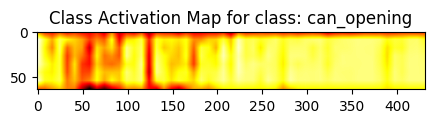

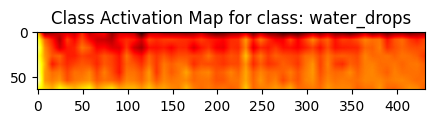

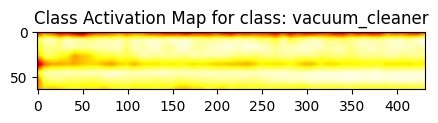

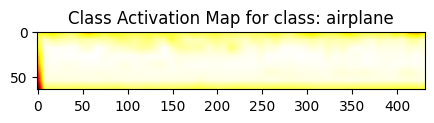

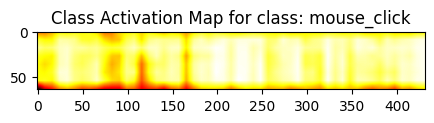

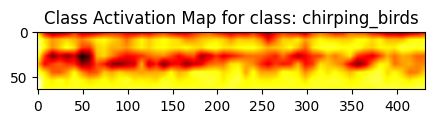

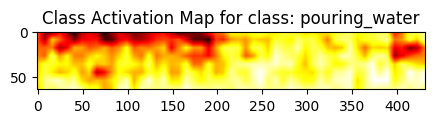

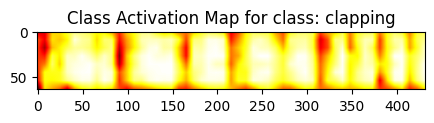

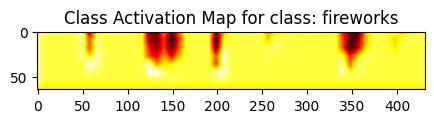

In [23]:
class_cams = {}
for key in cams.keys():
    class_cams[key] = np.mean(cams[key], axis=0)

for key in class_cams.keys():
    plt.figure(figsize=(5, 10))
    plt.imshow(class_cams[key], cmap='hot')
    plt.title(f"Class Activation Map for class: {key}")
    #plt.colorbar()
    plt.show()

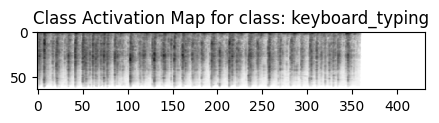

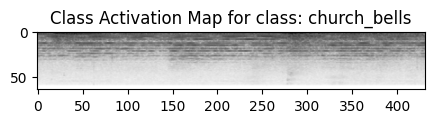

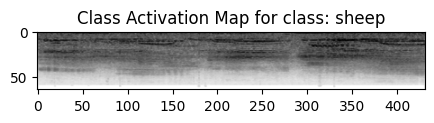

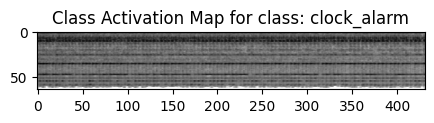

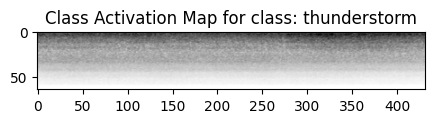

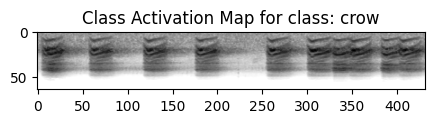

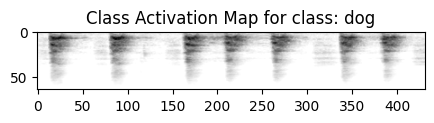

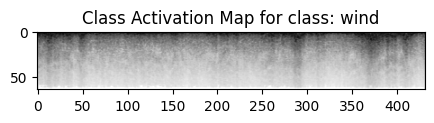

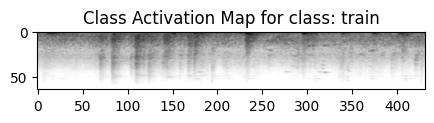

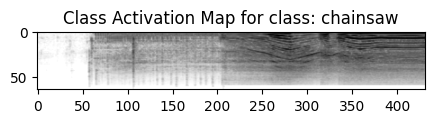

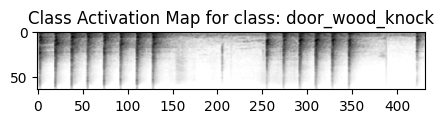

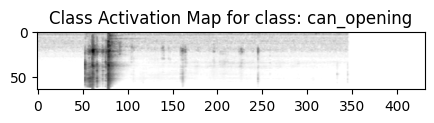

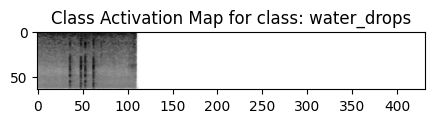

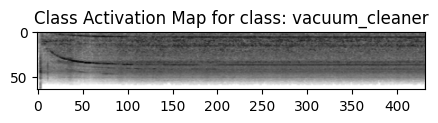

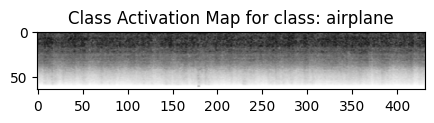

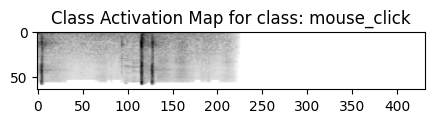

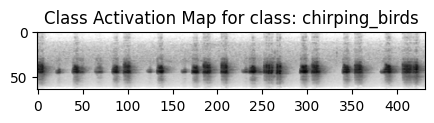

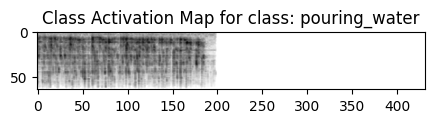

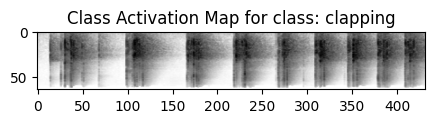

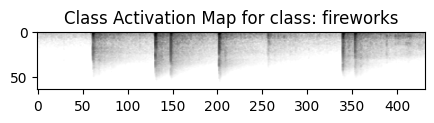

In [35]:
for key in samples.keys():
    plt.figure(figsize=(5, 10))
    plt.imshow(samples[key][0], cmap='Greys')
    plt.title(f"Class Activation Map for class: {key}")
    #plt.colorbar()
    plt.show()

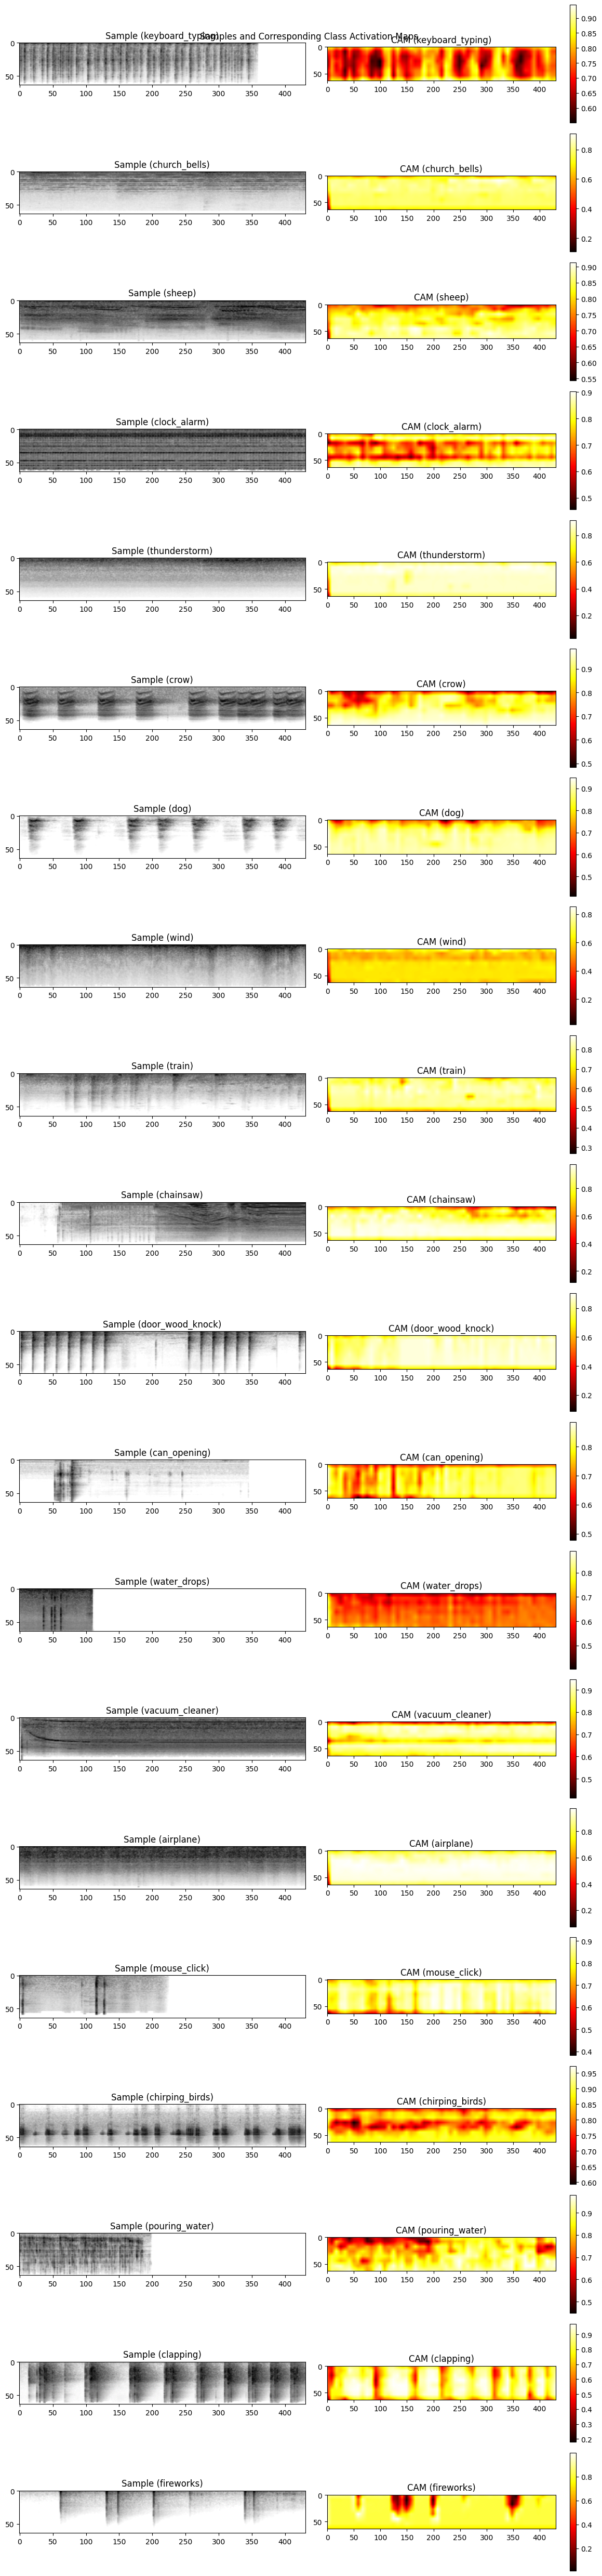

In [37]:
fig, axs = plt.subplots(len(samples.keys()), 2, figsize=(12, 2.5*len(samples.keys())))
fig.suptitle('Samples and Corresponding Class Activation Maps')

# Plot samples and CAMs side by side
for idx, key in enumerate(samples.keys()):
    # Left subplot - Sample
    axs[idx, 0].imshow(samples[key][0], cmap='Greys')
    axs[idx, 0].set_title(f'Sample ({key})')
    
    # Right subplot - CAM
    im = axs[idx, 1].imshow(class_cams[key], cmap='hot')
    axs[idx, 1].set_title(f'CAM ({key})')
    
    # Add colorbar to CAM subplot
    fig.colorbar(im, ax=axs[idx, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

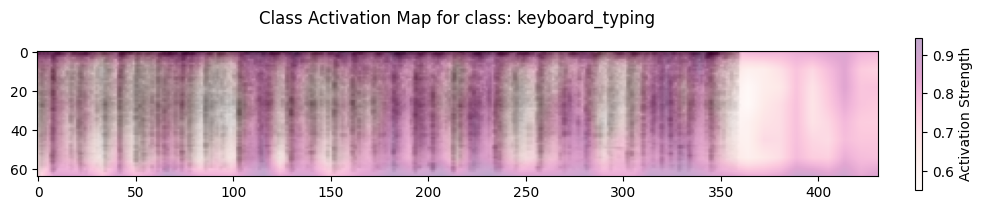

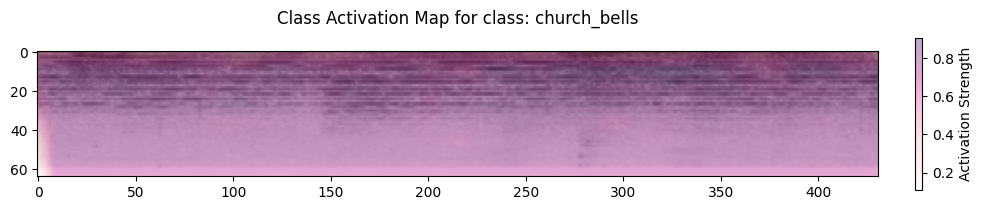

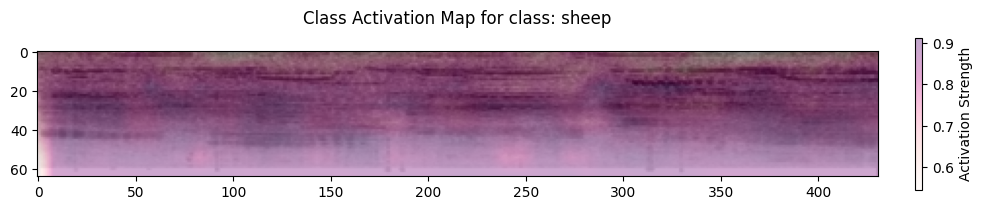

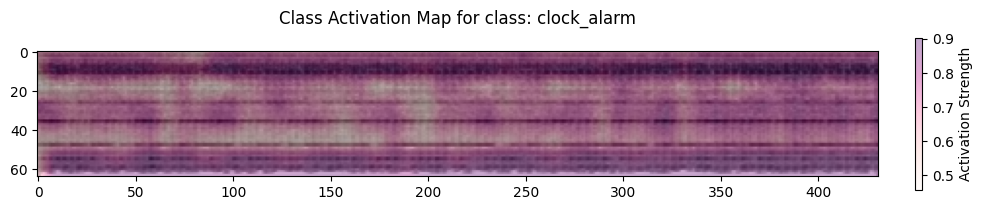

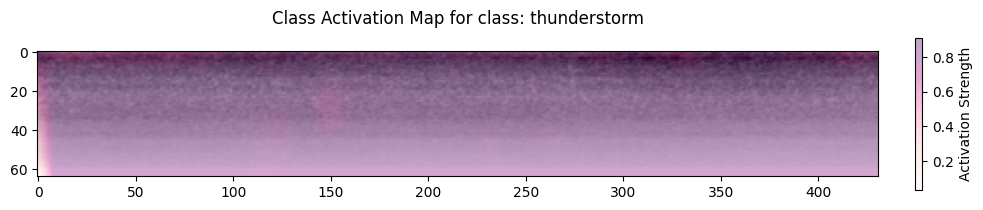

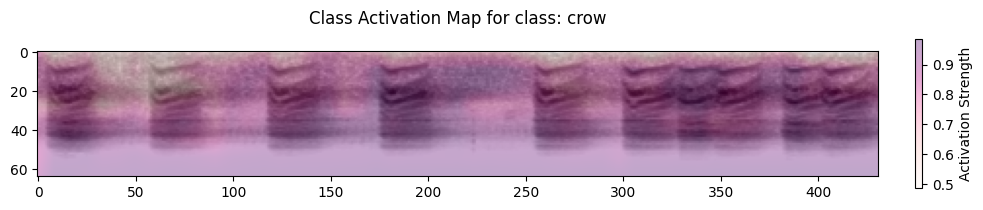

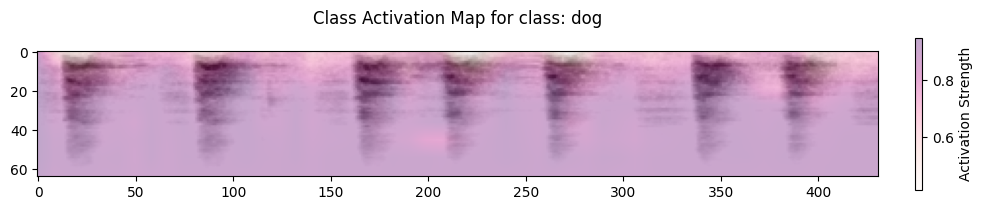

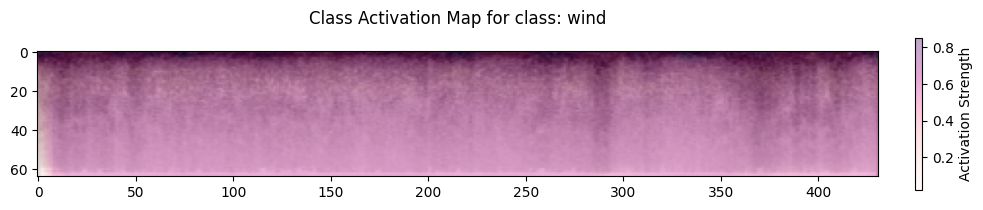

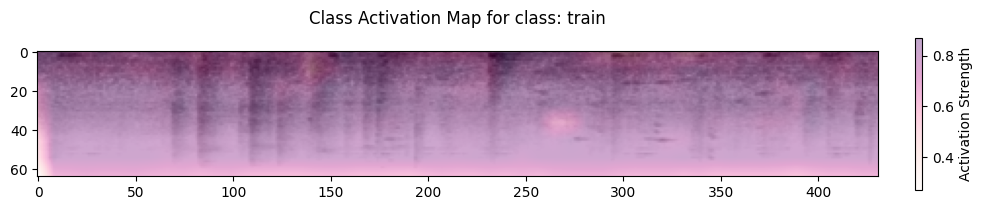

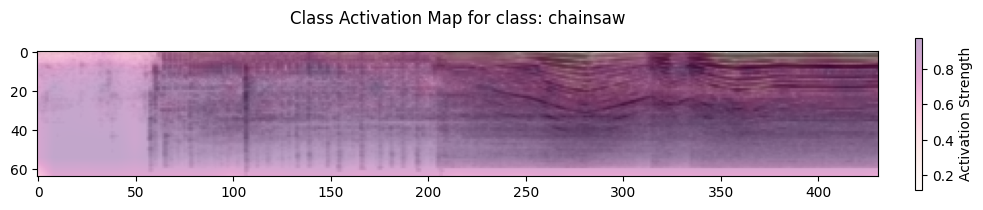

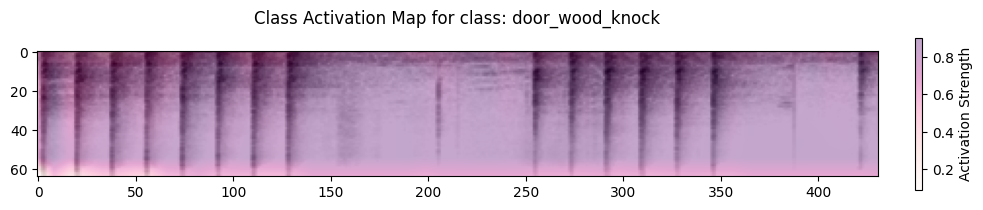

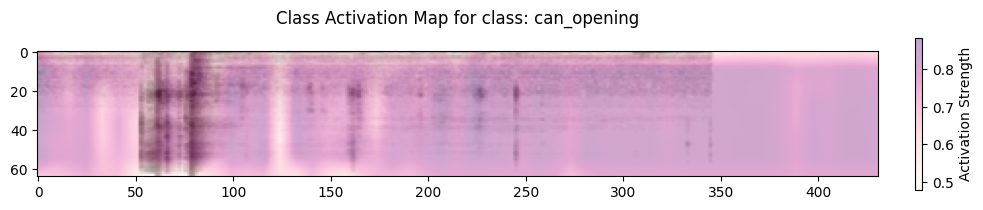

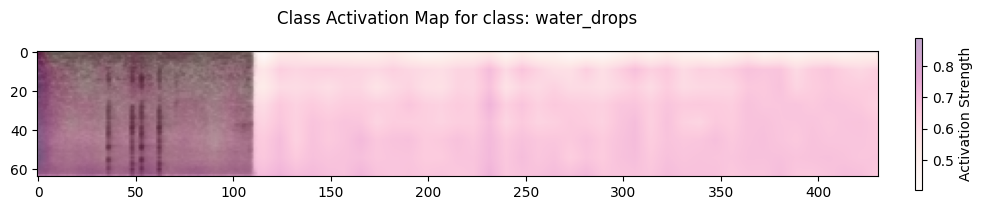

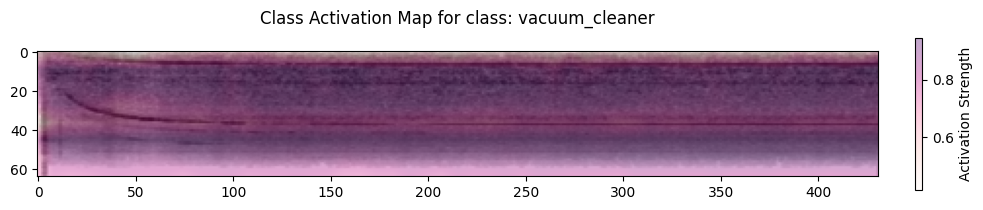

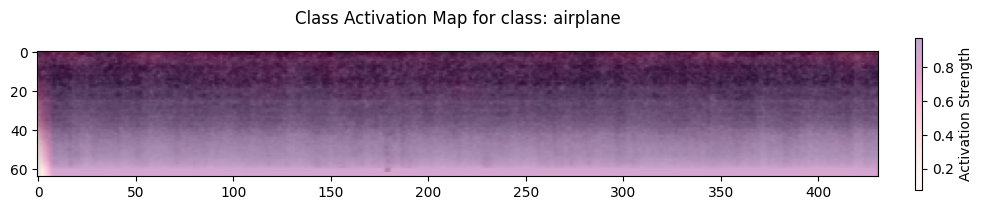

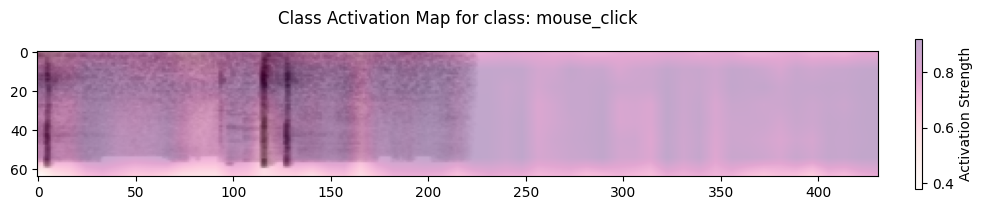

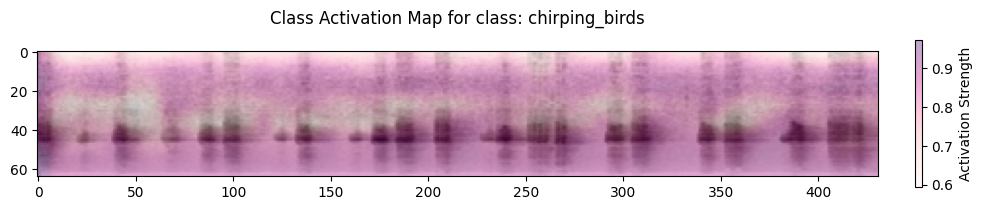

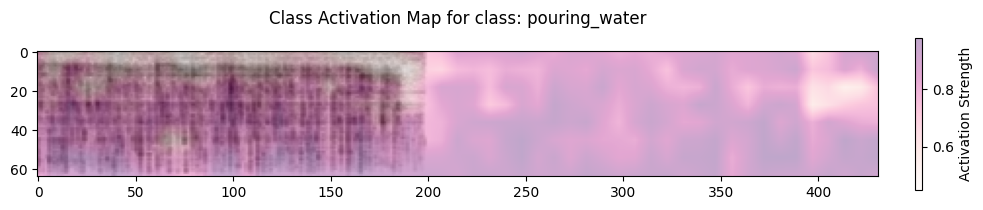

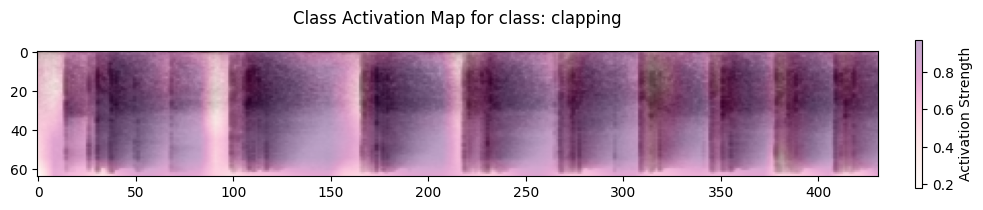

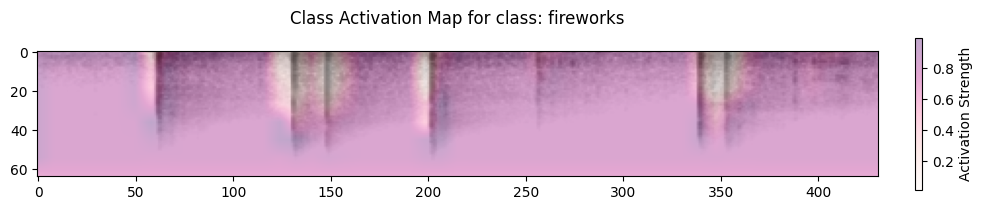

In [39]:
for key in class_cams.keys():
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.imshow(samples[key][0], cmap='Greys')
    im = ax.imshow(class_cams[key], cmap='RdPu', alpha=0.35)
    plt.title(f"Class Activation Map for class: {key}", pad=20)
    plt.colorbar(im, label='Activation Strength', fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

